# Fuzzing with Generators

In this chapter, we show how to extend grammars with _functions_ – pieces of code that get executed during grammar expansion, and that can generate, check, or change elements produced.  Adding functions to a grammar allows for very versatile test generation, bringing together the best of grammar generation and programming.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('oeMxtboPD_s')

**Prerequisites**

* As this chapter deeply interacts with the techniques discussed in the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb), a good understanding of the techniques is recommended.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.GeneratorGrammarFuzzer import <identifier>
```

and then make use of the following features.


This chapter introduces the ability to attach _functions_ to individual production rules:

* A `pre` function is executed _before_ the expansion takes place.  Its result (typically a string) can _replace_ the actual expansion.
* A `post` function is executed _after_ the expansion has taken place.  If it returns a string, the string replaces the expansion; it it returns `False`, it triggers a new expansion.

Both functions can return `None` to not interfere with grammar production at all.

To attach a function `F` to an individual expansion `S` in a grammar, replace `S` with a pair

```python
(S, opts(pre=F))   # Set a function to be executed before expansion
```
or
```python
(S, opts(post=F))  # Set a function to be executed after expansion
```

Here is an example, To take an area code from a list that is given programmatically, we can write:

```python
>>> from Grammars import US_PHONE_GRAMMAR, extend_grammar, opts
>>> def pick_area_code():
>>>     return random.choice(['555', '554', '553'])
>>> PICKED_US_PHONE_GRAMMAR = extend_grammar(US_PHONE_GRAMMAR,
>>> {
>>>     "<area>": [("<lead-digit><digit><digit>", opts(pre=pick_area_code))]
>>> })
```
A `GeneratorGrammarFuzzer` will extract and interpret these options.  Here is an example:

```python
>>> picked_us_phone_fuzzer = GeneratorGrammarFuzzer(PICKED_US_PHONE_GRAMMAR)
>>> [picked_us_phone_fuzzer.fuzz() for i in range(5)]
['(553)200-6118',
 '(553)889-0205',
 '(555)317-0936',
 '(553)455-2577',
 '(553)263-8511']
```
As you can see, the area codes now all stem from `pick_area_code()`.  Such definitions allow to closely tie program code (such as `pick_area_code()`) to grammars.

The `PGGCFuzzer` class incorporates all features from [the `GrammarFuzzer` class](GrammarFuzzer.ipynb) and its [coverage-based](GrammarCoverageFuzzer.ipynb), [probabilistic-based](ProbabilisticGrammarFuzzer.ipynb), and [generator-based](GeneratorGrammarFuzzer.ipynb) derivatives.

![](PICS/GeneratorGrammarFuzzer-synopsis-1.svg)



## Example: Test a Credit Card System

Suppose you work with a shopping system that – among several other features – allows customers to pay with a credit card.  Your task is to test the payment functionality.  

To make things simple, we will assume that we need only two pieces of data – a 16-digit credit card number and an amount to be charged.  Both pieces can be easily generated with grammars, as in the following:

In [2]:
import bookutils

In [3]:
from typing import Callable, Set, List, Dict, Optional, Iterator, Any, Union, Tuple, cast

In [4]:
from Fuzzer import Fuzzer

In [5]:
from Grammars import EXPR_GRAMMAR, is_valid_grammar, is_nonterminal, extend_grammar
from Grammars import opts, exp_opt, exp_string, crange, Grammar, Expansion

In [6]:
from GrammarFuzzer import DerivationTree

In [7]:
CHARGE_GRAMMAR: Grammar = {
    "<start>": ["Charge <amount> to my credit card <credit-card-number>"],
    "<amount>": ["$<float>"],
    "<float>": ["<integer>.<digit><digit>"],
    "<integer>": ["<digit>", "<integer><digit>"],
    "<digit>": crange('0', '9'),

    "<credit-card-number>": ["<digits>"],
    "<digits>": ["<digit-block><digit-block><digit-block><digit-block>"],
    "<digit-block>": ["<digit><digit><digit><digit>"],
}

In [8]:
assert is_valid_grammar(CHARGE_GRAMMAR)

All of this works neatly – we can generate arbitrary amounts and credit card numbers:

In [9]:
from GrammarFuzzer import GrammarFuzzer, all_terminals

In [10]:
g = GrammarFuzzer(CHARGE_GRAMMAR)
[g.fuzz() for i in range(5)]

['Charge $9.40 to my credit card 7166898575638313',
 'Charge $8.79 to my credit card 6845418694643271',
 'Charge $5.64 to my credit card 6655894657077388',
 'Charge $0.60 to my credit card 2596728464872261',
 'Charge $8.90 to my credit card 2363769342732142']

However, when actually testing our system with this data, we find two problems:

1. We'd like to test _specific_ amounts being charged – for instance, amounts that would excess the credit card limit.
2. We find that 9 out of 10 credit card numbers are rejected because of having an incorrect checksum.  This is fine if we want to test rejection of credit card numbers – but if we want to test the actual functionality of processing a charge, we need _valid_ numbers.

We could go and ignore these issues; after all, eventually, it is only a matter of time until large amounts and valid numbers are generated.  As it comes to the first concern, we could also address it by changing the grammar appropriately – say, to only produce charges that have at least six leading digits.  However, generalizing this to arbitrary ranges of values will be cumbersome.

The second concern, the checksums of credit card numbers, however, runs deeper – at least as far as grammars are concerned, is that a complex arithmetic operation like a checksum cannot be expressed in a grammar alone – at least not in the _context-free grammars_ we use here.  (In principle, one _could_ do this in a  _context–sensitive_ grammar, but specifying this would be no fun at all.)  What we want is a mechanism that allows us to _attach programmatic computations_ to our grammars, bringing together the best of both worlds.

## Attaching Functions to Expansions

The key idea of this chapter is to _extend_ grammars such that one can _attach Python functions_ to individual expansions.  These functions can be executed 

1. _before_ expansion, _replacing_ the element to be expanded by a computed value; or
2. _after_ expansion, _checking_ generated elements, and possibly also replacing them.

In both cases, functions are specified using the `opts()` expansion mechanism introduced in the [chapter on grammars](Grammars.ipynb).  They are thus tied to a specific expansion $e$ of a symbol $s$.

### Functions Called Before Expansion

A function defined using the `pre` option is invoked _before_ expansion of $s$ into $e$. Its value _replaces_ the expansion $e$ to be produced.  To generate a value for the credit card example, above, we could define a _pre-expansion_ generator function

In [11]:
import random

In [12]:
def high_charge() -> float:
    return random.randint(10000000, 90000000) / 100.0

With `opts()`, we could attach this function to the grammar:

In [13]:
CHARGE_GRAMMAR.update({
    "<float>": [("<integer>.<digit><digit>", opts(pre=high_charge))],
})

with the intention that whenever `<float>` is expanded, the function `high_charge` would be invoked to generate a value for `<float>`.  (The actual expansion in the grammar would still be present for fuzzers that ignore functions, such as `GrammarFuzzer`).

Since functions tied to a grammar are frequently very simple, we can also _inline_ them using a *lambda* expression.  A _lambda expression_ is used for _anonymous_ functions that are limited in scope and functionality.  Here's an example:

In [14]:
def apply_twice(function, x):
    return function(function(x))

In [15]:
apply_twice(lambda x: x * x, 2)

16

Here, we don't have to give the `function` to be applied twice a name (say, `square()`); instead, we apply it inline within the invocation.

Using `lambda`, this is what our grammar looks like:

In [16]:
CHARGE_GRAMMAR.update({
    "<float>": [("<integer>.<digit><digit>",
                 opts(pre=lambda: random.randint(10000000, 90000000) / 100.0))]
})

### Functions Called After Expansion

A function defined using the `post` option is invoked _after_ expansion of $s$ into $e$, passing the expanded values of the symbols in $e$ as arguments.  A post-expansion function can serve in two ways:

1. It can serve as a *constraint* or _filter_ on the expanded values, returning `True` if the expansion is valid, and `False` if not; if it returns `False`, another expansion is attempted.
2. It can also serve as a *repair*, returning a string value; like pre-expansion functions, the returned value replaces the expansion.

For our credit card example, we can choose both ways.  If we have a function `check_credit_card(s)` which returns `True` for a valid number `s` and `False` for invalid ones, we would go for the first option:

In [17]:
CHARGE_GRAMMAR.update({
    "<credit-card-number>": [("<digits>", opts(post=lambda digits: check_credit_card(digits)))]
})

With such a filter, only valid credit cards will be produced.  On average, it will still take 10 attempts for each time `check_credit_card()` is satisfied, but then, we do not have to recourse to the system under test.

If we have a function `fix_credit_card(s)` which changes the number such that the checksum is valid and returns the "fixed" number, we can make use of this one instead:

In [18]:
CHARGE_GRAMMAR.update({
    "<credit-card-number>": [("<digits>", opts(post=lambda digits: fix_credit_card(digits)))]
})

Here, each number is generated only once and then repaired.  This is very efficient.

The checksum function used for credit cards is the [Luhn algorithm](https://en.wikipedia.org/wiki/Luhn_algorithm), a simple yet effective formula.

In [19]:
def luhn_checksum(s: str) -> int:
    """Compute Luhn's check digit over a string of digits"""
    LUHN_ODD_LOOKUP = (0, 2, 4, 6, 8, 1, 3, 5, 7,
                       9)  # sum_of_digits (index * 2)

    evens = sum(int(p) for p in s[-1::-2])
    odds = sum(LUHN_ODD_LOOKUP[int(p)] for p in s[-2::-2])
    return (evens + odds) % 10

In [20]:
def valid_luhn_checksum(s: str) -> bool:
    """Check whether the last digit is Luhn's checksum over the earlier digits"""
    return luhn_checksum(s[:-1]) == int(s[-1])

In [21]:
def fix_luhn_checksum(s: str) -> str:
    """Return the given string of digits, with a fixed check digit"""
    return s[:-1] + repr(luhn_checksum(s[:-1]))

In [22]:
luhn_checksum("123")

8

In [23]:
fix_luhn_checksum("123x")

'1238'

We can make use of these functions in our credit card grammar:

In [24]:
check_credit_card: Callable[[str], bool] = valid_luhn_checksum
fix_credit_card: Callable[[str], str] = fix_luhn_checksum

In [25]:
fix_credit_card("1234567890123456")

'1234567890123458'

## A Class for Integrating Constraints

While it is easy to specify functions, our grammar fuzzer will simply ignore them just as it ignores all extensions.  It will issue a warning, though:

In [26]:
g = GrammarFuzzer(CHARGE_GRAMMAR)
g.fuzz()

'Charge $4.05 to my credit card 0637034038177393'

We need to define a special fuzzer that actually invokes the given `pre` and `post` functions and acts accordingly.  We name this a `GeneratorGrammarFuzzer`:

In [27]:
class GeneratorGrammarFuzzer(GrammarFuzzer):
    def supported_opts(self) -> Set[str]:
        return super().supported_opts() | {"pre", "post", "order"}

We define custom functions to access the `pre` and `post` options:

In [28]:
def exp_pre_expansion_function(expansion: Expansion) -> Optional[Callable]:
    """Return the specified pre-expansion function, or None if unspecified"""
    return exp_opt(expansion, 'pre')

In [29]:
def exp_post_expansion_function(expansion: Expansion) -> Optional[Callable]:
    """Return the specified post-expansion function, or None if unspecified"""
    return exp_opt(expansion, 'post')

The `order` attribute will be used [later in this chapter](#Ordering-Expansions).

## Generating Elements before Expansion

Our first task will be implementing the pre-expansion functions – that is, the function that would be invoked _before_ expansion to replace the value to be expanded.  To this end, we hook into the `process_chosen_children()` method, which gets the selected children before expansion.  We set it up such that it invokes the given `pre` function and applies its result on the children, possibly replacing them.

In [30]:
import inspect

In [31]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def process_chosen_children(self, children: List[DerivationTree],
                                expansion: Expansion) -> List[DerivationTree]:
        function = exp_pre_expansion_function(expansion)
        if function is None:
            return children

        assert callable(function)
        if inspect.isgeneratorfunction(function):
            # See "generators", below
            result = self.run_generator(expansion, function)
        else:
            result = function()

        if self.log:
            print(repr(function) + "()", "=", repr(result))
        return self.apply_result(result, children)

    def run_generator(self, expansion: Expansion, function: Callable):
        ...

The method `apply_result()` takes the result from the pre-expansion function and applies it on the children.  The exact effect depends on the type of the result:

* A _string_ $s$ replaces the entire expansion with $s$.
* A _list_ $[x_1, x_2, \dots, x_n]$ replaces the $i$-th symbol with $x_i$ for every $x_i$ that is not `None`.  Specifying `None` as a list element $x_i$ is useful to leave that element unchanged.  If $x_i$ is not a string, it is converted to a string.
* A value of `None` is ignored.  This is useful if one wants to simply call a function upon expansion, with no effect on the expanded strings.
* _Boolean_ values are ignored.  This is useful for post-expansion functions, discussed below.
* All _other types_ are converted to strings, replacing the entire expansion.

In [32]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def apply_result(self, result: Any,
                     children: List[DerivationTree]) -> List[DerivationTree]:
        if isinstance(result, str):
            children = [(result, [])]
        elif isinstance(result, list):
            symbol_indexes = [i for i, c in enumerate(children)
                              if is_nonterminal(c[0])]

            for index, value in enumerate(result):
                if value is not None:
                    child_index = symbol_indexes[index]
                    if not isinstance(value, str):
                        value = repr(value)
                    if self.log:
                        print(
                            "Replacing", all_terminals(
                                children[child_index]), "by", value)

                    # children[child_index] = (value, [])
                    child_symbol, _ = children[child_index]
                    children[child_index] = (child_symbol, [(value, [])])
        elif result is None:
            pass
        elif isinstance(result, bool):
            pass
        else:
            if self.log:
                print("Replacing", "".join(
                    [all_terminals(c) for c in children]), "by", result)

            children = [(repr(result), [])]

        return children

### Example: Numeric Ranges

With the above extensions, we have full support for pre-expansion functions.  Using the augmented `CHARGE_GRAMMAR`, we find that the pre-expansion `lambda` function is actually used:

In [33]:
charge_fuzzer = GeneratorGrammarFuzzer(CHARGE_GRAMMAR)
charge_fuzzer.fuzz()

'Charge $439383.87 to my credit card 2433506594138520'

The log reveals a bit more details what happens when the pre-expansion function is called.  We see that the expansion `<integer>.<digit><digit>` is directly replaced by the computed value:

In [34]:
amount_fuzzer = GeneratorGrammarFuzzer(
    CHARGE_GRAMMAR, start_symbol="<amount>", log=True)
amount_fuzzer.fuzz()

Tree: <amount>
Expanding <amount> randomly
Tree: $<float>
Expanding <float> randomly
<function <lambda> at 0x109b8e700>() = 382087.72
Replacing <integer>.<digit><digit> by 382087.72
Tree: $382087.72
'$382087.72'


'$382087.72'

### Example: More Numeric Ranges

We can use such pre-expansion functions in other contexts, too.  Suppose we want to generate arithmetic expressions in which each number is between 100 and 200.  We can extend `EXPR_GRAMMAR` accordingly:

In [35]:
expr_100_200_grammar = extend_grammar(EXPR_GRAMMAR,
                                      {
                                          "<factor>": [
                                              "+<factor>", "-<factor>", "(<expr>)",

                                              # Generate only the integer part with a function;
                                              # the fractional part comes from
                                              # the grammar
                                              ("<integer>.<integer>", opts(
                                                  pre=lambda: [random.randint(100, 200), None])),

                                              # Generate the entire integer
                                              # from the function
                                              ("<integer>", opts(
                                                  pre=lambda: random.randint(100, 200))),
                                          ],
                                      }
                                      )

In [36]:
expr_100_200_fuzzer = GeneratorGrammarFuzzer(expr_100_200_grammar)
expr_100_200_fuzzer.fuzz()

'(108.6 / 155 + 177) / 118 * 120 * 107 + 151 + 195 / -200 - 150 * 188 / 147 + 112'

### Support for Python Generators

The Python language has its own concept of generator functions, which we of course want to support as well.  A *generator function in Python* is a function that returns a so-called *iterator object* which we can iterate over, one value at a time.

To create a generator function in Python, one defines a normal function, using the `yield` statement instead of a `return` statement.  While a `return` statement terminates the function, a `yield` statement pauses its execution, saving all of its state, to be resumed later for the next successive calls.

Here is an example of a generator function.  When first invoked, `iterate()` yields the value 1, followed by 2, 3, and so on:

In [37]:
def iterate():
    t = 0
    while True:
        t = t + 1
        yield t

We can use `iterate` in a loop, just like the `range()` function (which also is a generator function):

In [38]:
for i in iterate():
    if i > 10:
        break
    print(i, end=" ")

1 2 3 4 5 6 7 8 9 10 

We can also use `iterate()` as a pre-expansion generator function, ensuring it will create one successive integer after another:

In [39]:
iterate_grammar = extend_grammar(EXPR_GRAMMAR,
                                 {
                                     "<factor>": [
                                         "+<factor>", "-<factor>", "(<expr>)",
                                         # "<integer>.<integer>",

                                         # Generate one integer after another
                                         # from the function
                                         ("<integer>", opts(pre=iterate)),
                                     ],
                                 })

To support generators, our `process_chosen_children()` method, above, checks whether a function is a generator; if so, it invokes the `run_generator()` method.  When `run_generator()` sees the function for the first time during a `fuzz_tree()` (or `fuzz()`) call, it invokes the function to create a generator object; this is saved in the `generators` attribute, and then called.  Subsequent calls directly go to the generator, preserving state.

In [40]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def fuzz_tree(self) -> DerivationTree:
        self.reset_generators()
        return super().fuzz_tree()

    def reset_generators(self) -> None:
        self.generators: Dict[str, Iterator] = {}

    def run_generator(self, expansion: Expansion,
                      function: Callable) -> Iterator:
        key = repr((expansion, function))
        if key not in self.generators:
            self.generators[key] = function()
        generator = self.generators[key]
        return next(generator)

Does this work?  Let us run our fuzzer on the above grammar, using `iterator()`:

In [41]:
iterate_fuzzer = GeneratorGrammarFuzzer(iterate_grammar)
iterate_fuzzer.fuzz()

'1 * ++++3 / ---+4 - 2 * +--6 / 7 * 10 - (9 - 11) - 5 + (13) * 14 + 8 + 12'

We see that the expression contains all integers starting with 1.

Instead of specifying our own Python generator function such as `iterate()`, we can also use one of the built-in Python generators such as `range()`.  This will also generate integers starting with 1:

In [42]:
iterate_grammar = extend_grammar(EXPR_GRAMMAR,
                                 {
                                     "<factor>": [
                                         "+<factor>", "-<factor>", "(<expr>)",
                                         ("<integer>", opts(pre=range(1, 1000))),
                                     ],
                                 })

It is also possible to use Python list comprehensions, by adding their generator functions in parentheses:

In [43]:
iterate_grammar = extend_grammar(EXPR_GRAMMAR,
                                 {
                                     "<factor>": [
                                         "+<factor>", "-<factor>", "(<expr>)",
                                         ("<integer>", opts(
                                             pre=(x for x in range(1, 1000)))),
                                     ],
                                 })

Note that both above grammars will actually cause the fuzzer to raise an exception when more than 1,000 integers are created, but you will find it very easy to fix this.

Finally, `yield` is actually an expression, not a statement, so it is also possible to have a `lambda` expression `yield` a value.  If you find some reasonable use for this, let us know.

## Checking and Repairing Elements after Expansion

Let us now turn to our second set of functions to be supported – namely, post-expansion functions.  The simplest way of using them is to run them once the entire tree is generated, taking care of replacements as with `pre` functions.  If one of them returns `False`, however, we start anew.

In [44]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def fuzz_tree(self) -> DerivationTree:
        while True:
            tree = super().fuzz_tree()
            (symbol, children) = tree
            result, new_children = self.run_post_functions(tree)
            if not isinstance(result, bool) or result:
                return (symbol, new_children)
            self.restart_expansion()

    def restart_expansion(self) -> None:
        # To be overloaded in subclasses
        self.reset_generators()

The method `run_post_functions()` is applied recursively on all nodes of the derivation tree.  For each node, it determines the expansion applied, and then runs the function associated with that expansion.

In [45]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    # Return True iff all constraints of grammar are satisfied in TREE
    def run_post_functions(self, tree: DerivationTree,
                           depth: Union[int, float] = float("inf")) \
                               -> Tuple[bool, Optional[List[DerivationTree]]]:
        symbol: str = tree[0]
        children: List[DerivationTree] = cast(List[DerivationTree], tree[1])

        if children == []:
            return True, children  # Terminal symbol

        try:
            expansion = self.find_expansion(tree)
        except KeyError:
            # Expansion (no longer) found - ignore
            return True, children

        result = True
        function = exp_post_expansion_function(expansion)
        if function is not None:
            result = self.eval_function(tree, function)
            if isinstance(result, bool) and not result:
                if self.log:
                    print(
                        all_terminals(tree),
                        "did not satisfy",
                        symbol,
                        "constraint")
                return False, children

            children = self.apply_result(result, children)

        if depth > 0:
            for c in children:
                result, _ = self.run_post_functions(c, depth - 1)
                if isinstance(result, bool) and not result:
                    return False, children

        return result, children

The helper method `find_expansion()` takes a subtree `tree` and determines the expansion from the grammar that was applied to create the children in `tree`.

In [46]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def find_expansion(self, tree):
        symbol, children = tree

        applied_expansion = \
            "".join([child_symbol for child_symbol, _ in children])

        for expansion in self.grammar[symbol]:
            if exp_string(expansion) == applied_expansion:
                return expansion

        raise KeyError(
            symbol +
            ": did not find expansion " +
            repr(applied_expansion))

The method `eval_function()` is the one that takes care of actually invoking the post-expansion function.  It creates an argument list containing the expansions of all nonterminal children – that is, one argument for each symbol in the grammar expansion.  It then calls the given function.

In [47]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def eval_function(self, tree, function):
        symbol, children = tree

        assert callable(function)

        args = []
        for (symbol, exp) in children:
            if exp != [] and exp is not None:
                symbol_value = all_terminals((symbol, exp))
                args.append(symbol_value)

        result = function(*args)
        if self.log:
            print(repr(function) + repr(tuple(args)), "=", repr(result))

        return result

Note that unlike pre-expansion functions, post-expansion functions typically process the values already produced, so we do not support Python generators here.

### Example: Negative Expressions

Let us try out these post-expression functions on an example.  Suppose we want to produce only arithmetic expressions that evaluate to a negative number – for instance, to feed such generated expressions into a compiler or some other external system.  Doing so constructively with `pre` functions would be very difficult. Instead, we can define a constraint that checks for precisely this property, using the Python `eval()` function.

The Python `eval()` function takes a string and evaluates it according to Python rules.  Since the syntax of our generated expressions is slightly different from Python, and since Python can raise arithmetic exceptions during evaluation, we need a means to handle such errors gracefully.  The function `eval_with_exception()` wraps around `eval()`; if an exception occurs during evaluation, it returns False – which causes the production algorithm to produce another value.

In [48]:
from ExpectError import ExpectError

In [49]:
def eval_with_exception(s):
    # Use "mute=True" to suppress all messages
    with ExpectError(print_traceback=False):
        return eval(s)
    return False

In [50]:
negative_expr_grammar = extend_grammar(EXPR_GRAMMAR,
                                       {
                                           "<start>": [("<expr>", opts(post=lambda s: eval_with_exception(s) < 0))]
                                       }
                                       )

assert is_valid_grammar(negative_expr_grammar)

In [51]:
negative_expr_fuzzer = GeneratorGrammarFuzzer(negative_expr_grammar)
expr = negative_expr_fuzzer.fuzz()
expr

ZeroDivisionError: division by zero (expected)


'(8.9 / 6 * 4 - 0.2 + -7 - 7 - 8 * 6) * 7 * 15.55 - -945.9'

The result is indeed negative:

In [52]:
eval(expr)

-5178.726666666667

### Example: Matching XML Tags

Post-expansion functions can not only be used to _check_ expansions, but also to repair them.  To this end, we can have them return a string or a list of strings; just like pre-expansion functions, these strings would then replace the entire expansion or individual symbols.

As an example, consider *XML documents*, which are composed of text within matching _XML tags_.  For instance, consider the following fragment in HTML, a subset of XML:

In [53]:
from bookutils import HTML

In [54]:
HTML("<strong>A bold text</strong>")

This fragment consists of two HTML (XML) tags that surround the text; the tag name (`strong`) is present both in the opening (`<strong>`) as well as in the closing (`</strong>`) tag.

For a _finite_ set of tags (for instance, the HTML tags `<strong>`, `<head>`, `<body>`, `<form>`, and so on), we could define a context-free grammar that parses it; each pair of tags would make up an individual rule in the grammar.  If the set of tags is _infinite_, though, as with general XML, we cannot define an appropriate grammar; that is because the constraint that the closing tag must match the opening tag is context-sensitive and thus does not fit context-free grammars.

(Incidentally, if the closing tag had the identifier _reversed_ (`</gnorts>`), then a context-free grammar could describe it.  Make this a programming exercise.)

We can address this problem by introducing appropriate post-expansion functions that automatically make the closing tag match the opening tag.  Let us start with a simple grammar for producing XML trees:

In [55]:
XML_GRAMMAR: Grammar = {
    "<start>": ["<xml-tree>"],
    "<xml-tree>": ["<<id>><xml-content></<id>>"],
    "<xml-content>": ["Text", "<xml-tree>"],
    "<id>": ["<letter>", "<id><letter>"],
    "<letter>": crange('a', 'z')
}

In [56]:
assert is_valid_grammar(XML_GRAMMAR)

If we fuzz using this grammar, we get non-matching XML tags, as expected:

In [57]:
xml_fuzzer = GrammarFuzzer(XML_GRAMMAR)
xml_fuzzer.fuzz()

'<t><qju>Text</m></q>'

Setting up a post-expansion function that sets the second identifier to the string found in the first solves the problem:

In [58]:
XML_GRAMMAR.update({
    "<xml-tree>": [("<<id>><xml-content></<id>>",
                    opts(post=lambda id1, content, id2: [None, None, id1])
                    )]
})

In [59]:
assert is_valid_grammar(XML_GRAMMAR)

In [60]:
xml_fuzzer = GeneratorGrammarFuzzer(XML_GRAMMAR)
xml_fuzzer.fuzz()

'<u>Text</u>'

### Example: Checksums

As our last example, let us consider the checksum problem from the introduction.  With our newly defined repair mechanisms, we can now generate credit card numbers that are valid: 

In [61]:
credit_card_fuzzer = GeneratorGrammarFuzzer(
    CHARGE_GRAMMAR, start_symbol="<credit-card-number>")
credit_card_number = credit_card_fuzzer.fuzz()
credit_card_number

'2967308746680770'

In [62]:
assert valid_luhn_checksum(credit_card_number)

The validity extends to the entire grammar:

In [63]:
charge_fuzzer = GeneratorGrammarFuzzer(CHARGE_GRAMMAR)
charge_fuzzer.fuzz()

'Charge $818819.97 to my credit card 2817984968014288'

## Local Checking and Repairing

So far, we have always first generated an entire expression tree, only to check it later for validity.  This can become expensive: If several elements are first generated only to find later that one of them is invalid, we spend a lot of time trying (randomly) to regenerate a matching input.

To demonstrate the issue, let us create an expression grammar in which all digits consist of zeros and ones.  Rather than doing this constructively, though, we filter out all non-conforming expressions after the fact, using a `post` constraint:

In [64]:
binary_expr_grammar = extend_grammar(EXPR_GRAMMAR,
                                     {
                                         "<integer>": [("<digit><integer>", opts(post=lambda digit, _: digit in ["0", "1"])),
                                                       ("<digit>", opts(post=lambda digit: digit in ["0", "1"]))]
                                     }
                                     )

In [65]:
assert is_valid_grammar(binary_expr_grammar)

This works, but is very slow; it can take several seconds before a matching expression is found.

In [66]:
binary_expr_fuzzer = GeneratorGrammarFuzzer(binary_expr_grammar)
binary_expr_fuzzer.fuzz()

'(-+0)'

We can address the problem by checking constraints not only for the final subtree, but also for partial subtrees as soon as they are complete.  To this end, we extend the method `expand_tree_once()` such that it invokes the post-expansion function as soon as all symbols in a subtree are expanded.

In [67]:
class RestartExpansionException(Exception):
    pass

In [68]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def expand_tree_once(self, tree: DerivationTree) -> DerivationTree:
        # Apply inherited method.  This also calls `expand_tree_once()` on all
        # subtrees.
        new_tree: DerivationTree = super().expand_tree_once(tree)

        (symbol, children) = new_tree
        if all([exp_post_expansion_function(expansion)
                is None for expansion in self.grammar[symbol]]):
            # No constraints for this symbol
            return new_tree

        if self.any_possible_expansions(tree):
            # Still expanding
            return new_tree

        return self.run_post_functions_locally(new_tree)

The main work takes place in the helper method `run_post_functions_locally()`.  It runs the post-expansion function $f$ with `run_post_functions()` only on the current node by setting `depth` to zero, as any completed subtrees would have their post-expansion functions ran already.  If $f$ returns `False`, `run_post_functions_locally()` returns an unexpanded symbol, such that the main driver can try another expansion.  It does so for up to 10 times (configurable via a `replacement_attempts` parameter during construction); after that, it raises a `RestartExpansionException` to restart creating the tree from scratch.

In [69]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def run_post_functions_locally(self, new_tree: DerivationTree) -> DerivationTree:
        symbol, _ = new_tree

        result, children = self.run_post_functions(new_tree, depth=0)
        if not isinstance(result, bool) or result:
            # No constraints, or constraint satisfied
            # children = self.apply_result(result, children)
            new_tree = (symbol, children)
            return new_tree

        # Replace tree by unexpanded symbol and try again
        if self.log:
            print(
                all_terminals(new_tree),
                "did not satisfy",
                symbol,
                "constraint")

        if self.replacement_attempts_counter > 0:
            if self.log:
                print("Trying another expansion")
            self.replacement_attempts_counter -= 1
            return (symbol, None)

        if self.log:
            print("Starting from scratch")
        raise RestartExpansionException

The class constructor method and `fuzz_tree()` are set up to handle the additional functionality: 

In [70]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def __init__(self, grammar: Grammar, replacement_attempts: int = 10,
                 **kwargs) -> None:
        super().__init__(grammar, **kwargs)
        self.replacement_attempts = replacement_attempts

    def restart_expansion(self) -> None:
        super().restart_expansion()
        self.replacement_attempts_counter = self.replacement_attempts

    def fuzz_tree(self) -> DerivationTree:
        self.replacement_attempts_counter = self.replacement_attempts
        while True:
            try:
                # This is fuzz_tree() as defined above
                tree = super().fuzz_tree()
                return tree
            except RestartExpansionException:
                self.restart_expansion()

In [71]:
binary_expr_fuzzer = GeneratorGrammarFuzzer(
    binary_expr_grammar, replacement_attempts=100)
binary_expr_fuzzer.fuzz()

'+0 / +-1 - 1 / +0 * -+0 * 0 * 1 / 1'

## Definitions and Uses

With the above generators and constraints, we can also address complex examples.  The `VAR_GRAMMAR` grammar from [the chapter on parsers](Parser.ipynb) defines a number of variables as arithmetic expressions (which in turn can contain variables, too).  Applying a simple `GrammarFuzzer` on the grammar produces plenty of identifiers, but each identifier has a unique name.

In [72]:
import string

In [73]:
VAR_GRAMMAR: Grammar = {
    '<start>': ['<statements>'],
    '<statements>': ['<statement>;<statements>', '<statement>'],
    '<statement>': ['<assignment>'],
    '<assignment>': ['<identifier>=<expr>'],
    '<identifier>': ['<word>'],
    '<word>': ['<alpha><word>', '<alpha>'],
    '<alpha>': list(string.ascii_letters),
    '<expr>': ['<term>+<expr>', '<term>-<expr>', '<term>'],
    '<term>': ['<factor>*<term>', '<factor>/<term>', '<factor>'],
    '<factor>':
    ['+<factor>', '-<factor>', '(<expr>)', '<identifier>', '<number>'],
    '<number>': ['<integer>.<integer>', '<integer>'],
    '<integer>': ['<digit><integer>', '<digit>'],
    '<digit>': crange('0', '9')
}

In [74]:
assert is_valid_grammar(VAR_GRAMMAR)

In [75]:
g = GrammarFuzzer(VAR_GRAMMAR)
for i in range(10):
    print(g.fuzz())

Gc=F/1*Y+M-D-9;N=n/(m)/m*7
a=79.0;W=o-9;v=2;K=u;D=9
o=y-z+y+4;q=5+W;X=T
M=-98.032*5/o
H=IA-5-1;n=3-t;QQ=5-5
Y=-80;d=D-M+M;Z=4.3+1*r-5+b
ZDGSS=(1*Y-4)*54/0*pcO/4;RI=r*5.0
Q=6+z-6;J=6/t/9/i-3-5+k
x=-GT*+-x*6++-93*5
q=da*T/e--v;x=3+g;bk=u


What we'd like is that within expressions, only identifiers _previously defined_ should be used.  To this end, we introduce a set of functions around a *symbol table*, which keeps track of all variables already defined.

In [76]:
SYMBOL_TABLE: Set[str] = set()

In [77]:
def define_id(id: str) -> None:
    SYMBOL_TABLE.add(id)

In [78]:
def use_id() -> Union[bool, str]:
    if len(SYMBOL_TABLE) == 0:
        return False

    id = random.choice(list(SYMBOL_TABLE))
    return id

In [79]:
def clear_symbol_table() -> None:
    global SYMBOL_TABLE
    SYMBOL_TABLE = set()

To make use of the symbol table, we attach pre- and post-expansion functions to `VAR_GRAMMAR` that define and lookup identifiers from the symbol table.  We name our extended grammar `CONSTRAINED_VAR_GRAMMAR`:

In [80]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(VAR_GRAMMAR)

First, we set up the grammar such that after each time an identifier is defined, we store its name in the symbol table:

In [81]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(CONSTRAINED_VAR_GRAMMAR, {
    "<assignment>": [("<identifier>=<expr>",
                      opts(post=lambda id, expr: define_id(id)))]
})

Second, we make sure that when an identifier is generated, we pick it from the symbol table, too.  (We use `post` here such that we can return `False` if no identifier is yet available, leading to another expansion being made.)

In [82]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(CONSTRAINED_VAR_GRAMMAR, {
    "<factor>": ['+<factor>', '-<factor>', '(<expr>)',
                 ("<identifier>", opts(post=lambda _: use_id())),
                 '<number>']
})

Finally, we clear the symbol table each time we (re)start an expansion.  This is helpful as we may occasionally have to restart expansions.

In [83]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(CONSTRAINED_VAR_GRAMMAR, {
    "<start>": [("<statements>", opts(pre=clear_symbol_table))]
})

In [84]:
assert is_valid_grammar(CONSTRAINED_VAR_GRAMMAR)

Fuzzing with this grammar ensures that each identifier used is actually defined:

In [85]:
var_grammar_fuzzer = GeneratorGrammarFuzzer(CONSTRAINED_VAR_GRAMMAR)
for i in range(10):
    print(var_grammar_fuzzer.fuzz())

DB=+(8/4/7-9+3+3)/2178/+-9
lNIqc=+(1+9-8)/2.9*8/5*0
Sg=(+9/8/6)*++1/(1+7)*8*4
r=+---552
iz=5/7/7;K=1+6*iz*1
q=3-2;MPy=q;p=2*5
zj=+5*-+35.2-+1.5727978+(-(-0/6-7+3))*--+44*1
Tl=((0*9+4-3)-6)/(-3-7*8*8/7)+9
aXZ=-5/-+3*9/3/1-8-+0*0/3+7+4
NA=-(8+a-1)*1.6;g=++7;a=++g*g*g


## Ordering Expansions

While our previous def/use example ensures that each _used_ variable also is a _defined_ variable, it does not take care of the _order_ in which these definitions are made.  In fact, it is possible that first, the term on the right hand side of a `;` expands, creating an entry in the symbol table, which is then later used in the expression on the left hand side.  We can demonstrate this by actually evaluating the produced variable assignments in Python, using `exec()` to execute the sequence of assignments.  (Little known fact: Python _does_ support `;` as statement separator.)

In [86]:
var_grammar_fuzzer = GeneratorGrammarFuzzer(CONSTRAINED_VAR_GRAMMAR)
with ExpectError():
    for i in range(100):
        s = var_grammar_fuzzer.fuzz()
        try:
            exec(s, {}, {})
        except SyntaxError:
            continue
        except ZeroDivisionError:
            continue
print(s)

f=(9)*kOj*kOj-6/7;kOj=(9-8)*7*1


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14428/3970000697.py", line 6, in <module>
    exec(s, {}, {})
  File "<string>", line 1, in <module>
NameError: name 'kOj' is not defined (expected)


To address this issue, we allow to explicitly specify an *ordering of expansions*.  For our previous fuzzers, such an ordering was inconsequential, as eventually, all symbols would be expanded; if we have expansion functions with side effects, though, having control over the ordering in which expansions are made (and thus over the ordering in which the associated functions are called) can be important.

To specify orderings, we assign a special attribute `order` to individual expansions.  This is a list with a number for each symbol in the expansion stating in which order the expansions are to be made, starting with the smallest one.  As an example, the following rule specifies that the left hand side of a `;` separator should be expanded first:

In [87]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(CONSTRAINED_VAR_GRAMMAR, {
    "<statements>": [("<statement>;<statements>", opts(order=[1, 2])),
                     "<statement>"]
})

Likewise, we want the definition of a variable to be produced only _after_ the expression is expanded, since otherwise, the expression might already refer to the defined variable:

In [88]:
CONSTRAINED_VAR_GRAMMAR = extend_grammar(CONSTRAINED_VAR_GRAMMAR, {
    "<assignment>": [("<identifier>=<expr>", opts(post=lambda id, expr: define_id(id),
                                                  order=[2, 1]))],
})

The helper `exp_order()` allows us to retrieve the order:

In [89]:
def exp_order(expansion):
    """Return the specified expansion ordering, or None if unspecified"""
    return exp_opt(expansion, 'order')

To control the ordering in which symbols are expanded, we hook into the method `choose_tree_expansion()`, which is specifically set for being extended in subclasses.  It proceeds through the list `expandable_children` of expandable children to choose from and matches them with the nonterminal children from the expansion to determine their order number.  The index `min_given_order` of the expandable child with the lowest order number is then returned, choosing this child for expansion.

In [90]:
class GeneratorGrammarFuzzer(GeneratorGrammarFuzzer):
    def choose_tree_expansion(self, tree: DerivationTree,
                              expandable_children: List[DerivationTree]) \
                              -> int:
        """Return index of subtree in `expandable_children`
           to be selected for expansion. Defaults to random."""
        (symbol, tree_children) = tree
        assert isinstance(tree_children, list)

        if len(expandable_children) == 1:
            # No choice
            return super().choose_tree_expansion(tree, expandable_children)

        expansion = self.find_expansion(tree)
        given_order = exp_order(expansion)
        if given_order is None:
            # No order specified
            return super().choose_tree_expansion(tree, expandable_children)

        nonterminal_children = [c for c in tree_children if c[1] != []]
        assert len(nonterminal_children) == len(given_order), \
            "Order must have one element for each nonterminal"

        # Find expandable child with lowest ordering
        min_given_order = None
        j = 0
        for k, expandable_child in enumerate(expandable_children):
            while j < len(
                    nonterminal_children) and expandable_child != nonterminal_children[j]:
                j += 1
            assert j < len(nonterminal_children), "Expandable child not found"
            if self.log:
                print("Expandable child #%d %s has order %d" %
                      (k, expandable_child[0], given_order[j]))

            if min_given_order is None or given_order[j] < min_given_order:
                min_given_order = k

        assert min_given_order is not None

        if self.log:
            print("Returning expandable child #%d %s" %
                  (min_given_order, expandable_children[min_given_order][0]))

        return min_given_order

With this, our fuzzer can now respect orderings, and all variables are properly defined:

In [91]:
var_grammar_fuzzer = GeneratorGrammarFuzzer(CONSTRAINED_VAR_GRAMMAR)
for i in range(100):
    s = var_grammar_fuzzer.fuzz()
    if i < 10:
        print(s)
    try:
        exec(s, {}, {})
    except SyntaxError:
        continue
    except ZeroDivisionError:
        continue

SAl=4/-(2.92+5.27)/-4*0/6/3
Z=+-7/+5.519*68/4*-+-(5/7+4)*(8*-1/0-1+6-0);o=2
j=-(8+1+5)-+8/7*5-2/9+4;t=j
S=-(9+9-1)--5+-8*4-1+8-2
VImBX=06/7*6*7++-(+5*7*2+9-0)
f=-7;j=(f*f*0)/-5*(f-f)-f*-1/f
W=85.3*-++(9-5)/76.82/-2/++8*7;j=W
xb=1*5*1*1-+0*3*7+2+9+0
Edd=(4+8)/+4-+8*2*7+++9*+-+08.9
u=-++33*+-6/(2*3*2+1/9-4*1-8)*((8.5))


Real programming languages not only have one global scope, but multiple local scopes, frequently nested.  By carefully organizing global and local symbol tables, we can set up a grammar to handle all of these.  However, when fuzzing compilers and interpreters, we typically focus on single functions, for which one single scope is enough to make most inputs valid.

## All Together

Let us close this chapter by integrating our generator features with the other grammar features introduced earlier, in particular [coverage-driven fuzzing](GrammarCoverageFuzzer.ipynb) and [probabilistic grammar fuzzing](ProbabilisticGrammarFuzzer.ipynb).

The general idea to integrate the individual features is through *multiple inheritance*, which we already used for `ProbabilisticGrammarCoverageFuzzer`, introduced in the [exercises on probabilistic fuzzing](ProbabilisticGrammarFuzzer.ipynb).

### Generators and Probabilistic Fuzzing

Probabilistic fuzzing integrates very easily with generators, as both extend `GrammarFuzzer` in different ways.

In [92]:
from ProbabilisticGrammarFuzzer import ProbabilisticGrammarFuzzer  # minor dependency

In [93]:
from bookutils import inheritance_conflicts

In [94]:
inheritance_conflicts(ProbabilisticGrammarFuzzer, GeneratorGrammarFuzzer)

['supported_opts']

We have to implement `supported_opts()` as the merger of both superclasses.  At the same time, we also set up the constructor such that it invokes both.

In [95]:
class ProbabilisticGeneratorGrammarFuzzer(GeneratorGrammarFuzzer,
                                          ProbabilisticGrammarFuzzer):
    """Join the features of `GeneratorGrammarFuzzer` 
    and `ProbabilisticGrammarFuzzer`"""

    def supported_opts(self) -> Set[str]:
        return (super(GeneratorGrammarFuzzer, self).supported_opts() |
                super(ProbabilisticGrammarFuzzer, self).supported_opts())

    def __init__(self, grammar: Grammar, *, replacement_attempts: int = 10,
                 **kwargs):
        """Constructor.
        `replacement_attempts` - see `GeneratorGrammarFuzzer` constructor.
        All other keywords go into `ProbabilisticGrammarFuzzer`.
        """
        super(GeneratorGrammarFuzzer, self).__init__(
                grammar,
                replacement_attempts=replacement_attempts)
        super(ProbabilisticGrammarFuzzer, self).__init__(grammar, **kwargs)

Let us give our joint class a simple test, using probabilities to favor long identifiers:

In [96]:
CONSTRAINED_VAR_GRAMMAR.update({
    '<word>': [('<alpha><word>', opts(prob=0.9)),
               '<alpha>'],
})

In [97]:
pgg_fuzzer = ProbabilisticGeneratorGrammarFuzzer(CONSTRAINED_VAR_GRAMMAR)
pgg_fuzzer.supported_opts()

{'order', 'post', 'pre', 'prob'}

In [98]:
pgg_fuzzer.fuzz()

'hfaHpaxvv=+-(8*-(7)*5-(4))/+-(-5*-43);h=7'

# Generators and Grammar Coverage

Fuzzing based on grammar coverage is a bigger challenge.  Not so much for the methods overloaded in both; we can resolve these just as above.

In [99]:
from ProbabilisticGrammarFuzzer import ProbabilisticGrammarCoverageFuzzer  # minor dependency

In [100]:
from GrammarCoverageFuzzer import GrammarCoverageFuzzer  # minor dependency

In [101]:
inheritance_conflicts(ProbabilisticGrammarCoverageFuzzer,
                      GeneratorGrammarFuzzer)

['__init__', 'supported_opts']

In [102]:
import copy

In [103]:
class ProbabilisticGeneratorGrammarCoverageFuzzer(GeneratorGrammarFuzzer,
                                                  ProbabilisticGrammarCoverageFuzzer):
    """Join the features of `GeneratorGrammarFuzzer` 
    and `ProbabilisticGrammarCoverageFuzzer`"""

    def supported_opts(self) -> Set[str]:
        return (super(GeneratorGrammarFuzzer, self).supported_opts() |
                super(ProbabilisticGrammarCoverageFuzzer, self).supported_opts())

    def __init__(self, grammar: Grammar, *,
                 replacement_attempts: int = 10, **kwargs) -> None:
        """Constructor.
        `replacement_attempts` - see `GeneratorGrammarFuzzer` constructor.
        All other keywords go into `ProbabilisticGrammarFuzzer`.
        """
        super(GeneratorGrammarFuzzer, self).__init__(
                grammar,
                replacement_attempts)
        super(ProbabilisticGrammarCoverageFuzzer, self).__init__(
                grammar,
                **kwargs)

The problem is that during expansion, we _may_ generate (and cover) expansions that we later drop (for instance, because a `post` function returns `False`).  Hence, we have to _remove_ this coverage which is no longer present in the final production.

We resolve the problem by _rebuilding the coverage_ from the final tree after it is produced.  To this end, we hook into the `fuzz_tree()` method.  We have it save the original coverage before creating the tree, restoring it afterwards.  Then we traverse the resulting tree, adding its coverage back again (`add_tree_coverage()`).

In [104]:
class ProbabilisticGeneratorGrammarCoverageFuzzer(
        ProbabilisticGeneratorGrammarCoverageFuzzer):

    def fuzz_tree(self) -> DerivationTree:
        self.orig_covered_expansions = copy.deepcopy(self.covered_expansions)
        tree = super().fuzz_tree()
        self.covered_expansions = self.orig_covered_expansions
        self.add_tree_coverage(tree)
        return tree

    def add_tree_coverage(self, tree: DerivationTree) -> None:
        (symbol, children) = tree
        assert isinstance(children, list)
        if len(children) > 0:
            flat_children: List[DerivationTree] = [
                (child_symbol, None)
                for (child_symbol, _) in children
            ]
            self.add_coverage(symbol, flat_children)
            for c in children:
                self.add_tree_coverage(c)

As a final step, we ensure that if we do have to restart an expansion from scratch, we also restore the previous coverage such that we can start fully anew:

In [105]:
class ProbabilisticGeneratorGrammarCoverageFuzzer(
        ProbabilisticGeneratorGrammarCoverageFuzzer):

    def restart_expansion(self) -> None:
        super().restart_expansion()
        self.covered_expansions = self.orig_covered_expansions

Let us try this out.  After we have produced a string, we should see its coverage in `expansion_coverage()`:

In [106]:
pggc_fuzzer = ProbabilisticGeneratorGrammarCoverageFuzzer(
    CONSTRAINED_VAR_GRAMMAR)
pggc_fuzzer.fuzz()

'sM=7/5*9++(-6/2/8)-4+1;g=3'

In [107]:
pggc_fuzzer.expansion_coverage()

{'<alpha> -> M',
 '<alpha> -> g',
 '<alpha> -> s',
 '<assignment> -> <identifier>=<expr>',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 7',
 '<digit> -> 8',
 '<digit> -> 9',
 '<expr> -> <term>',
 '<expr> -> <term>+<expr>',
 '<expr> -> <term>-<expr>',
 '<factor> -> (<expr>)',
 '<factor> -> +<factor>',
 '<factor> -> -<factor>',
 '<factor> -> <number>',
 '<identifier> -> <word>',
 '<integer> -> <digit>',
 '<number> -> <integer>',
 '<start> -> <statements>',
 '<statement> -> <assignment>',
 '<statements> -> <statement>',
 '<statements> -> <statement>;<statements>',
 '<term> -> <factor>',
 '<term> -> <factor>*<term>',
 '<term> -> <factor>/<term>',
 '<word> -> <alpha>',
 '<word> -> <alpha><word>'}

Fuzzing again would eventually cover all letters in identifiers:

In [108]:
[pggc_fuzzer.fuzz() for i in range(10)]

['tIbFSBC=0/7/8+9*2/1*9;m=7',
 'LHkGcwXqTUzODjWhRruVo=6/4/5/6+1+7+5*1-2',
 'QYePndypZKxNafAElvILv=551.3;ZRhYGwEfIDYSfiunr=02.45*(2+0)+3*QYePndypZKxNafAElvILv+QYePndypZKxNafAElvILv/7',
 'uIQHzf=(4/8)/5/-8-+(9-3+9+8+0)/++-2',
 'DWNVzzWELL=((3+4)-++4/9*0+67)/(50169.1*3)',
 'NVKZ=-011/++82.4*-(5*6*6)/97.3/-3/1',
 'O=+(2*(8)*2+(7/0))/+-6*+0.3*8',
 'RMfynoao=-+02/(7)*8--9+8*5/3-5+9',
 'k=2/3/4.7*6---+-3;q=1',
 'MR=49*1++21-5/6/2*5;x=MR']

With `ProbabilisticGeneratorGrammarCoverageFuzzer`, we now have a grammar fuzzer that combines efficient grammar fuzzing with coverage, probabilities, and generator functions.  The only thing that is missing is a shorter name.  `PGGCFuzzer`, maybe?

In [109]:
class PGGCFuzzer(ProbabilisticGeneratorGrammarCoverageFuzzer):
    """The one grammar-based fuzzer that supports all fuzzingbook features"""
    pass

## Synopsis

This chapter introduces the ability to attach _functions_ to individual production rules:

* A `pre` function is executed _before_ the expansion takes place.  Its result (typically a string) can _replace_ the actual expansion.
* A `post` function is executed _after_ the expansion has taken place.  If it returns a string, the string replaces the expansion; it it returns `False`, it triggers a new expansion.

Both functions can return `None` to not interfere with grammar production at all.

To attach a function `F` to an individual expansion `S` in a grammar, replace `S` with a pair

```python
(S, opts(pre=F))   # Set a function to be executed before expansion
```
or
```python
(S, opts(post=F))  # Set a function to be executed after expansion
```

Here is an example, To take an area code from a list that is given programmatically, we can write:

In [110]:
from Grammars import US_PHONE_GRAMMAR, extend_grammar, opts

In [111]:
def pick_area_code():
    return random.choice(['555', '554', '553'])

In [112]:
PICKED_US_PHONE_GRAMMAR = extend_grammar(US_PHONE_GRAMMAR,
{
    "<area>": [("<lead-digit><digit><digit>", opts(pre=pick_area_code))]
})

A `GeneratorGrammarFuzzer` will extract and interpret these options.  Here is an example:

In [113]:
picked_us_phone_fuzzer = GeneratorGrammarFuzzer(PICKED_US_PHONE_GRAMMAR)
[picked_us_phone_fuzzer.fuzz() for i in range(5)]

['(553)200-6118',
 '(553)889-0205',
 '(555)317-0936',
 '(553)455-2577',
 '(553)263-8511']

As you can see, the area codes now all stem from `pick_area_code()`.  Such definitions allow to closely tie program code (such as `pick_area_code()`) to grammars.

The `PGGCFuzzer` class incorporates all features from [the `GrammarFuzzer` class](GrammarFuzzer.ipynb) and its [coverage-based](GrammarCoverageFuzzer.ipynb), [probabilistic-based](ProbabilisticGrammarFuzzer.ipynb), and [generator-based](GeneratorGrammarFuzzer.ipynb) derivatives.

In [114]:
# ignore
from ClassDiagram import display_class_hierarchy

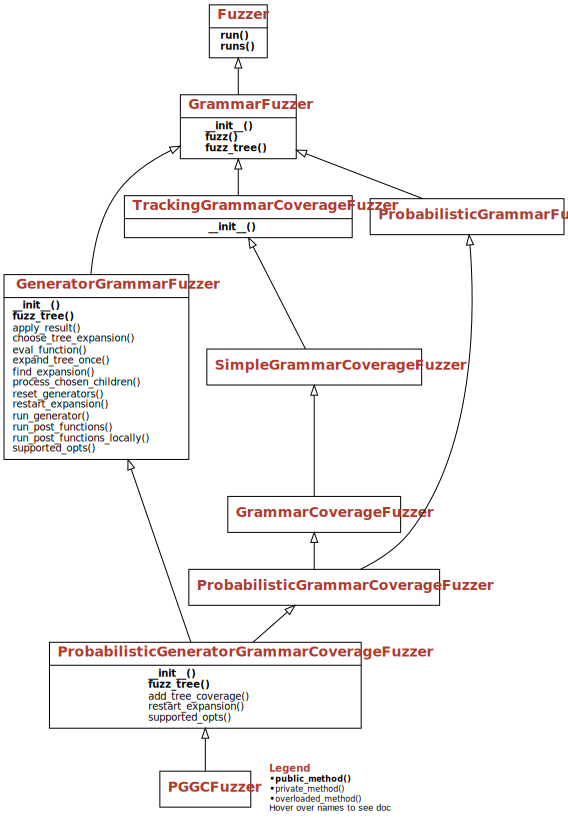

In [115]:
# ignore
display_class_hierarchy([PGGCFuzzer],
                        public_methods=[
                            Fuzzer.run,
                            Fuzzer.runs,
                            GrammarFuzzer.__init__,
                            GrammarFuzzer.fuzz,
                            GrammarFuzzer.fuzz_tree,
                            GeneratorGrammarFuzzer.__init__,
                            GeneratorGrammarFuzzer.fuzz_tree,
                            GrammarCoverageFuzzer.__init__,
                            ProbabilisticGrammarFuzzer.__init__,
                            ProbabilisticGrammarCoverageFuzzer.__init__,
                            ProbabilisticGeneratorGrammarCoverageFuzzer.__init__,
                            ProbabilisticGeneratorGrammarCoverageFuzzer.fuzz_tree,
                            PGGCFuzzer.__init__,
                        ],
                        types={
                            'DerivationTree': DerivationTree,
                            'Expansion': Expansion,
                            'Grammar': Grammar
                        },
                        project='fuzzingbook')

## Lessons Learned

Functions attached to grammar expansions can serve 
* as _generators_ to efficiently produce a symbol expansion from a function;
* as _constraints_ to check produced strings against (complex) validity conditions; and
* as _repairs_ to apply changes to produced strings, such as checksums and identifiers.

## Next Steps

With this chapter, we have powerful grammars which we can use in a number of domains:

* In the [chapter on fuzzing APIs](APIFuzzer.ipynb), we show how to produce complex data structures for testing, making use of `GeneratorGrammarFuzzer` features to combine grammars and generator functions.
* In the [chapter on fuzzing User Interfaces](WebFuzzer.ipynb), we make use of `GeneratorGrammarFuzzer` to produce complex user interface inputs.


## Background

For fuzzing APIs, generator functions are very common.  In the [chapter on API fuzzing](APIFuzzer.ipynb), we show how to combine them with grammars for even richer test generation.

The combination of generator functions and grammars is mostly possible because we define and make use of grammars in an all-Python environment.  We are not aware of another grammar-based fuzzing system that exhibits similar features.

## Exercises


### Exercise 1: Tree Processing

So far, our `pre` and `post` processing functions all accept and produce strings.  In some circumstances, however, it can be useful to access the _derivation trees_ directly – for instance, to access and check some child element.

Your task is to extend `GeneratorGrammarFuzzer` with pre- and post-processing functions that can accept and return derivation trees.  To this end, proceed as follows:

1. Extend `GeneratorGrammarFuzzer` such that a function can return a derivation tree (a tuple) or a list of derivation trees, which would then replace subtrees in the same way as strings.
2. Extend `GeneratorGrammarFuzzer` with a `post_tree` attribute which takes a function just like `post`, except that its arguments would be derivation trees.

**Solution.** Left to the reader at this point.

### Exercise 2: Attribute Grammars

Set up a mechanism through which it is possible to attach arbitrary _attributes_ to individual elements in the derivation tree.  Expansion functions could attach such attributes to individual symbols (say, by returning `opts()`), and also access attributes of symbols in later calls.  Here is an example:

In [116]:
ATTR_GRAMMAR = {
    "<clause>": [("<xml-open>Text<xml-close>", opts(post=lambda x1, x2: [None, x1.name]))],
    "<xml-open>": [("<<tag>>", opts(post=lambda tag: opts(name=...)))],
    "<xml-close>": ["</<tag>>"]
}

**Solution.** Left to the reader at this point.